### Imports

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import sys

### Defining of a simple scrape and clean function

In [2]:

def get_question_page(page_no, page_size, tab, is_tagged=False, tag=None):
    
    page = None
    soup = None
    try:
        page_no = str(page_no)
        page_size = str(page_size)


        if is_tagged:
            # arg3 is required
            if not tag:
                raise ValueError("tag is required when is_tagged is True")
            else:
                page = requests.get(f"https://stackoverflow.com/questions/tagged/{tag}?tab={tab}&page={page_no}&pagesize={page_size}", timeout=100)
        else:
            page = requests.get(f"https://stackoverflow.com/questions?tab={tab}&page={page_no}pagesize={page_size}", timeout=100)


        # Parse it in BeautifulSoup
        soup = BeautifulSoup(page.text, 'lxml')
        if soup.text == '404':
            print("Page not found")
            sys.exit()
    except requests.exceptions.ConnectionError:
        print("Restarting 'get_question_page'")
        page, soup = get_question_page(page_no, page_size, tab, is_tagged=False, tag=None)
    return page, soup

def get_all_questions(page_no, page_size, tab, file_path, is_tagged=False, tag=None):
    answer_texts = []
    titles = []
    votes = []
    answers = []
    view_counts = []
    tags = []

    page, soup = get_question_page(page_no, page_size, tab, is_tagged, tag)
    
    # Get all the questions from the question box
    questions = soup.find_all(class_="s-post-summary")

    # Save different data in lists:


    for question in questions:
        # Title
        titles.append(question.find(class_="s-link").text)

        # Stats
        stats = (question.find(class_="s-post-summary--stats")).findChildren("div")
        vote = int(stats[0].find(class_="s-post-summary--stats-item-number").text)
        votes.append(vote)
        answer = int(stats[1].find(class_="s-post-summary--stats-item-number").text)
        answers.append(answer)
        views = int(stats[2].find(class_="s-post-summary--stats-item-number").text)
        view_counts.append(views)

        # Tags
        tags_ = question.find_all(class_="js-post-tag-list-item")
        tags_text = []
        for tag in tags_:
            
            tags_text.append(tag.text)
        tags.append(tags_text)


    # Cleaning of data and conversion to Data Frame
    dict_ = {
        'Title': titles, 
        'Votes': votes, 
        'Answers': answers, 
        'Views': view_counts,
        'Tags': tags
    }

    df = pd.DataFrame(dict_)

    df.to_csv(f'{file_path}')
    return df

### Test our simple function

In [3]:
dataframe = pd.DataFrame({
        'Title': [], 
        'Votes': [], 
        'Answers': [], 
        'Views': [],
        'Tags': []
    })
for i in range(3):
    dataframe = pd.concat([dataframe, get_all_questions(i, 30, 'newest', 'python_questions.csv', True, 'python')], axis=0, ignore_index=True)
    
print(dataframe)
    
# This should return a dataframe of all 'newest' questions found in the 'python' tag that can be seen in the first '3 pages'. This dataframe will be saved as a csv file 'python_questions.csv'

                                                 Title  Votes  Answers  Views  \
0    Interacting With Dynamic Data Table And Scrapi...    0.0      0.0    2.0   
1    XSLT Pandas - How to Pull the Grandchild value...    0.0      0.0    9.0   
2    My Python-Selenium project automates creating ...    0.0      0.0    6.0   
3    Plot specific dataframe columns as subplots vi...    0.0      0.0    8.0   
4    Parsing OData Select and Expand failed: Term '...    0.0      0.0    6.0   
..                                                 ...    ...      ...    ...   
145  AttributeError: module 'discord' has no attrib...   -3.0      0.0   18.0   
146                  Unable to print particle [closed]   -3.0      0.0   13.0   
147  Type change after Operator Overloading in Pyth...   -1.0      0.0   17.0   
148          Moviepy increases the length of the video    0.0      0.0    9.0   
149  How do I create a 2D plot from three columns i...    0.0      0.0   15.0   

                           

This returns all the questions for the given arguments.
Now that we have a good chunk of data, let's start extracting insight from it.
My first thought will be to try to extract insights from the tags section: What tags are the most common used with Python.
This can actually help us to determine which subjects are most related to python on the platform.
In order to do this, we have to manipulate the function in order to collect all the available tags.

In [4]:
# Here, we define one more variable: tags_available
tags_available = []
def get_all_questions(page_no, page_size, tab, file_path, is_tagged=False, tag=None):
    answer_texts = []
    titles = []
    votes = []
    answers = []
    view_counts = []
    tags = []
    page, soup = get_question_page(page_no, page_size, tab, is_tagged, tag)

    questions = soup.find_all(class_="s-post-summary")



    for question in questions:
        titles.append(question.find(class_="s-link").text)
        stats = (question.find(class_="s-post-summary--stats")).findChildren("div")
        vote = int(stats[0].find(class_="s-post-summary--stats-item-number").text)
        votes.append(vote)
        answer = int(stats[1].find(class_="s-post-summary--stats-item-number").text)
        answers.append(answer)
        views = int(stats[2].find(class_="s-post-summary--stats-item-number").text)
        view_counts.append(views)
        tags_ = question.find_all(class_="js-post-tag-list-item")
        tags_text = []
        for tag in tags_:
            
            # Here, we check if the tag is not currently appended to tags_available. If not, we will append it.
            if (tag.text not in tags_available):
                tags_available.append(tag.text)
            tags_text.append(tag.text)
        tags.append(tags_text)


    dict_ = {
        'Title': titles, 
        'Votes': votes, 
        'Answers': answers, 
        'Views': view_counts,
        'Tags': tags
    }

    df = pd.DataFrame(dict_)

    df.to_csv(f'{file_path}')
    return df
    

In [5]:
dataframe = pd.DataFrame({
        'Title': [], 
        'Votes': [], 
        'Answers': [], 
        'Views': [],
        'Tags': []
    })
for i in range(3):
    dataframe = pd.concat([dataframe, get_all_questions(i, 30, 'newest', 'python_questions.csv', True, 'python')], axis=0, ignore_index=True)
    
print(dataframe)
print(tags_available)  # Let's print the tags_available to see what we get

                                                 Title  Votes  Answers  Views  \
0    Interacting With Dynamic Data Table And Scrapi...    0.0      0.0    2.0   
1    XSLT Pandas - How to Pull the Grandchild value...    0.0      0.0   10.0   
2    My Python-Selenium project automates creating ...    0.0      0.0    6.0   
3    Plot specific dataframe columns as subplots vi...    0.0      0.0    8.0   
4    Parsing OData Select and Expand failed: Term '...    0.0      0.0    6.0   
..                                                 ...    ...      ...    ...   
145  AttributeError: module 'discord' has no attrib...   -3.0      0.0   18.0   
146                  Unable to print particle [closed]   -3.0      0.0   13.0   
147  Type change after Operator Overloading in Pyth...   -1.0      0.0   17.0   
148          Moviepy increases the length of the video    0.0      0.0    9.0   
149  How do I create a 2D plot from three columns i...    0.0      0.0   15.0   

                           

Perfect 👌. This returns not only the dataframe, but it also gives us a list of all the tags available.

So let's use some pandas magic to extract some information here.

In [6]:
tag_count = []

for tag in tags_available:
    temp_df = dataframe[dataframe['Tags'].apply(lambda x: tag in x)]
    tag_count.append(len(temp_df))


print(tag_count)

[150, 5, 2, 2, 15, 2, 2, 2, 2, 2, 2, 9, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 6, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 6, 2, 5, 2, 2, 2, 2, 2, 7, 2, 2, 6, 2, 2, 2, 2, 8, 2, 3, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Here we determine the frequency of each tag in available_tags and save it to a variable tag_count

In order to be able to visualize this better, why don't we make a plot diagram using matplotlib

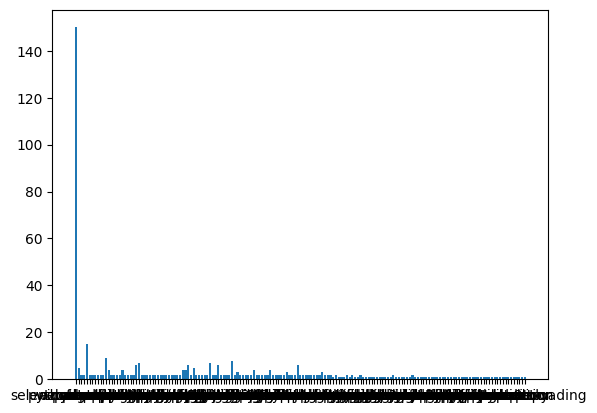

In [7]:
from matplotlib import pyplot as plt
plt.bar(tags_available, tag_count)
plt.show()

The code snippet did give us what we wanted, but perhaps not in the best format. There are two main problems with this:
1. We included the python tag in the list even though we already know it will have a count of 150.
2. We included way to many tags.

In order to fix these, we have to make a few adjustments to our code.

First, we have to remove the outlier tag - python - from the dataset

In [8]:
tags_available, tag_count = tags_available[1:], tag_count[1:]

Second, we make sure we are keeping track of only the 15 highest occuring tags

In [9]:
tags_dict = {
    'Tags Available': tags_available, 
    'Tags Count': tag_count,
}
tags_dataframe = pd.DataFrame(tags_dict)
tags_dataframe = tags_dataframe.sort_values(by='Tags Count', ascending=False)
tags_dataframe_highest_15 = tags_dataframe.iloc[0:15, :]
print(tags_dataframe_highest_15)

        Tags Available  Tags Count
3               pandas          15
10           dataframe           9
56          python-3.x           8
48             pytorch           7
22                 pip           7
80    machine-learning           6
51              django           6
40          tensorflow           6
21          sqlalchemy           6
0   selenium-webdriver           5
42       deep-learning           5
70               flask           4
38          discord.py           4
39              string           4
16              pytest           4


This looks much better, now lets visualize it as a bar chart

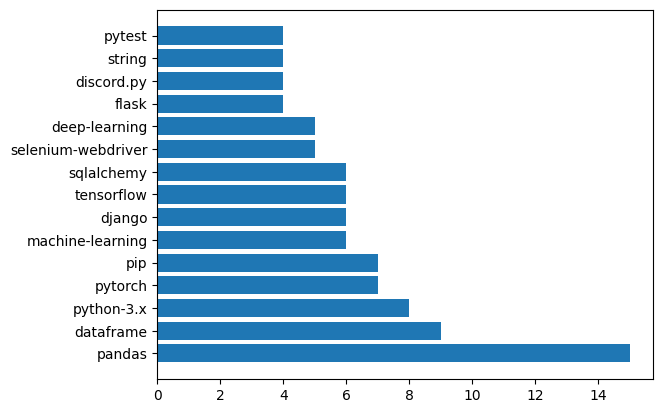

In [10]:
plt.barh(tags_dataframe_highest_15['Tags Available'], tags_dataframe_highest_15['Tags Count'])
plt.show()

## Top Rated Answers

First of all, we need to navigate into the answer page of each question.

In order to do this, we need to modify our get_all_questions function to include answers.

In [11]:
def get_all_questions(page_no, page_size, tab, file_path, is_tagged=False, tag=None):
    df = None
    try:
        titles = []
        votes = []
        answers = []
        answer_texts = []
        view_counts = []
        tags = []
        page, soup = get_question_page(page_no, page_size, tab, is_tagged, tag)

        # Get all the questions from the question box
        questions = soup.find_all(class_="s-post-summary")

        # Save different data in lists:


        for question in questions:

            # Title
            titles.append(question.find(class_="s-link").text)

            # Stats
            stats = (question.find(class_="s-post-summary--stats")).findChildren("div")
            vote = int(stats[0].find(class_="s-post-summary--stats-item-number").text)
            votes.append(vote)
            answer = int(stats[1].find(class_="s-post-summary--stats-item-number").text)
            answers.append(answer)
            views = int(stats[2].find(class_="s-post-summary--stats-item-number").text)
            view_counts.append(views)

            # Answer

            answer_page_link = f"https://stackoverflow.com{(question.a)['href']}"

            answer_page = requests.get(answer_page_link, timeout=100)
            soup2 = BeautifulSoup(answer_page.text, 'lxml')
            # Get the top rated answer
            answer_box = soup2.find(id="answers")
            answer_paragraphs = []
            if (answer_box != None):
                answer_paragraphs = [_.text for _ in answer_box.find_all('p') if (answer > 0)]
            answer_texts.append(answer_paragraphs)

            # Tags
            tags_ = question.find_all(class_="js-post-tag-list-item")
            tags_text = []
            for tag in tags_:

                tags_text.append(tag.text)
            tags.append(tags_text)


        # Cleaning of data and conversion to Data Frame
        dict_ = {
            'Title': titles,
            'Answers': answer_texts,
            'Votes': votes, 
            'Answer_Count': answers, 
            'Views': view_counts,
            'Tags': tags
        }

        df = pd.DataFrame(dict_)

        df.to_csv(f'{file_path}')
    except requests.exceptions.ConnectionError:
        print("Restarting 'get_all_questions'")
        df = get_all_questions(page_no, page_size, tab, file_path, is_tagged=False, tag=None)
    return df

In [12]:
dataframe = pd.DataFrame({
        'Title': [],
        'Answers': [], 
        'Votes': [],
        'Answer_Count': [],
        'Views': [],
        'Tags': []
    })
for i in range(1):
    dataframe = pd.concat([dataframe, get_all_questions(i+1, 20, 'newest', 'python_questions.csv', True, 'python')], axis=0, ignore_index=True)
    
print(dataframe)

                                                Title  \
0   Interacting With Dynamic Data Table And Scrapi...   
1   XSLT Pandas - How to Pull the Grandchild value...   
2   My Python-Selenium project automates creating ...   
3   Plot specific dataframe columns as subplots vi...   
4   Parsing OData Select and Expand failed: Term '...   
5       HOW TO MAKE A SLIDING PUZZLE SOLVER IN PYTHON   
6   Pytest: Specify different environments for dif...   
7   python - using eval() to assign or replace val...   
8   i wrote a code to get optional data from inter...   
9   sqlalchemy: how to customize standard type lik...   
10          why i can't install surprise in my device   
11        Problems with xlwings sheet.range(a,b)value   
12  How does Pandas DataFrame reindex function wor...   
13  Is there any hosting service that allows you t...   
14             Default Constructor not showing output   
15  Log Viewer with custom PyQt/PySide Scrollbar w...   
16       How do i make my bot r

Our code has been modified. We have successfully added a new column (Answers) to the Data Frame.

## Sentimental Analysis

What if we were able to determine the communities overall attitude towards a particular programming language or technology?
In order to do this, we will have to take the sentimental analysis score of each question corresponding to a particular programming language or technology and take the average of all these scores.

First of all, it would be convinient for us to compile the for loop as its own function as such:

In [13]:
def compile_questions(pages, questions_per_page, tab, file_path, is_tagged, tag):
    dataframe = None
    try:
        dataframe = pd.DataFrame({
            'Title': [],
            'Answers': [], 
            'Votes': [],
            'Answer_Count': [],
            'Views': [],
            'Tags': []
        })
        for i in range(pages):
            dataframe = pd.concat([dataframe, get_all_questions(i+1, questions_per_page, tab, file_path, is_tagged, tag)], axis=0, ignore_index=True)
    except requests.exceptions.ConnectionError:
        print("Restart 'compile_questions'")
        dataframe = compile_questions(pages, questions_per_page, tab, file_path, is_tagged, tag)
    return dataframe

Let's do a final test on our function

In [14]:
df = compile_questions(1, 40, 'newest', 'python_questions.csv', False, '')
print(df)

                                                Title  \
0               trouble with logging array properties   
1   Why I do get this error: Cannot read propertie...   
2   Interacting With Dynamic Data Table And Scrapi...   
3   What are all the features you look for in a no...   
4   How can I extract only specific data fields wh...   
5         How to auto save only if worksheet is open?   
6     React.ComponentPropsWithRef vs React.forwardRef   
7   Kmm library throwing No matching variant of wa...   
8   Build Issue in Release Mode with R8, After Xam...   
9   How to avoid blocking connect() on unresponsiv...   
10        Visualising RDF Triples using D3.js and Vue   
11        upload multiple template in my online store   
12  GoogleJsonResponseException: API call to peopl...   
13  Azure key vault: TLS 1.0 is no longer accepted...   
14            Filter Yaml documents by a key using yq   
15  Is there an alternative to --add-opens command...   
16  React - variables not getti

In order to get the sentimentals of all the languages and technologies on stackoverflow, we must target the tags that are available.

We can do this by defining a function named get_tags that will do this for us.

In [15]:
# https://stackoverflow.com/tags?page={page}&tab={tab}
# class="post-tag"
def get_tag_page(pages, tab):
    tags = []
    try:
        for i in range(pages):
            html_page = requests.get(f"https://stackoverflow.com/tags?page={i+1}&tab={tab}")
            soup = BeautifulSoup(html_page.text, 'lxml')
            tags_elem = soup.find_all(class_="post-tag")
            tags += [tag.text for tag in tags_elem]
            for i, tag in enumerate(tags):
                tags[i] = tag.replace("#", "%23")
                tags[i] = tags[i].replace("+", "%2B")
    except requests.exceptions.ConnectionError:
        print("Restart 'get_tag_page'")
        tags = get_tag_page(pages, tab)
    return tags

In [16]:
tags = get_tag_page(3, 'popular')
print(tags)

['javascript', 'python', 'java', 'c%23', 'php', 'android', 'html', 'jquery', 'c%2B%2B', 'css', 'ios', 'sql', 'mysql', 'r', 'node.js', 'reactjs', 'arrays', 'c', 'asp.net', 'json', 'python-3.x', 'ruby-on-rails', '.net', 'sql-server', 'swift', 'django', 'angular', 'objective-c', 'pandas', 'excel', 'angularjs', 'regex', 'ruby', 'linux', 'ajax', 'typescript', 'iphone', 'xml', 'vba', 'spring', 'laravel', 'asp.net-mvc', 'database', 'wordpress', 'string', 'mongodb', 'postgresql', 'wpf', 'flutter', 'windows', 'xcode', 'amazon-web-services', 'bash', 'git', 'oracle', 'dataframe', 'spring-boot', 'firebase', 'list', 'vb.net', 'multithreading', 'azure', 'react-native', 'docker', 'eclipse', 'algorithm', 'macos', 'powershell', 'visual-studio', 'image', 'forms', 'numpy', 'scala', 'function', 'api', 'vue.js', 'twitter-bootstrap', 'selenium', 'performance', 'winforms', 'loops', 'python-2.7', 'matlab', 'hibernate', 'express', 'sqlite', 'rest', 'apache', 'shell', 'entity-framework', 'kotlin', 'dart', 'andr

We now have a way to retrieve and store all the tags present on 'n' pages.

Now we can weave together all the functions that we have in order to get the questions corresepoding to these tags.

In [17]:
!pip install textblob


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from textblob import TextBlob
tags = get_tag_page(1, 'popular')
polarities = []
for tag in tags[:7]:
    df = compile_questions(1, 9, 'newest', 'questions.csv', True, tag)
    total_polarity = 0
    for title in df['Title']:
        polarity = (TextBlob(title)).polarity
        total_polarity += polarity
    average_polarity = total_polarity / len(df)
    polarities.append(average_polarity)
    print(f"{tag} done.")

javascript done.
python done.
java done.
c%23 done.
php done.
android done.
html done.


In [19]:
print(tags[:7], polarities)

['javascript', 'python', 'java', 'c%23', 'php', 'android', 'html'] [-0.02505303030303031, -0.012833333333333337, -0.009952380952380954, -0.011, 0.014863636363636362, -0.025666666666666664, 0.008435064935064934]


So now we get the tags and the average polarity tied to them. With this, we might be able to tell which languages and technologies people have the most problems with.

All that is left now is to visualize them.

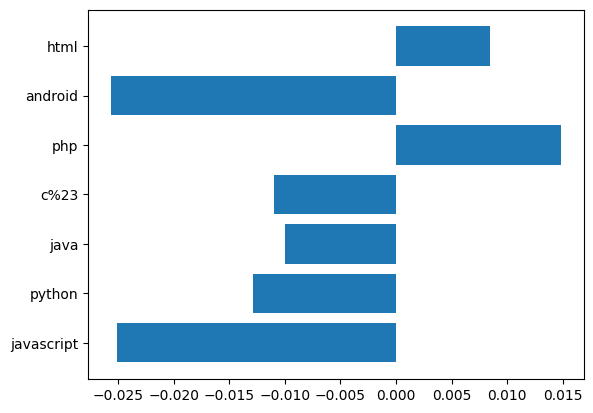

In [20]:
plt.barh(tags[0:7], polarities)
plt.show()

This gives us a rough estimate of how much each language or technology is associated with being problematic or complex. Of course, the accuracy of this quick calculation will become better the more data you include.

In [21]:
tags = get_tag_page(1, 'popular')
polarities = []
for tag in tags:
    df = compile_questions(1, 9, 'newest', 'questions.csv', True, tag)
    total_polarity = 0
    for title in df['Title']:
        polarity = (TextBlob(title)).polarity
        total_polarity += polarity
    average_polarity = total_polarity / len(df)
    polarities.append(average_polarity)
    print(f"{tag} done.")

javascript done.
python done.
java done.
c%23 done.
php done.
android done.
html done.
jquery done.
c%2B%2B done.
css done.
ios done.
sql done.
mysql done.
r done.
node.js done.
reactjs done.
arrays done.
c done.
asp.net done.
json done.
python-3.x done.
ruby-on-rails done.
.net done.
sql-server done.
swift done.
django done.
angular done.
objective-c done.
pandas done.
excel done.
angularjs done.
regex done.
ruby done.
linux done.


ValueError: invalid literal for int() with base 10: '2k'

## Trending Tracker

What if we had a way to track the rise an fall of activity regarding particular technologies relative to others? In order to do this, we have to create a loop that iterates through a list of tags.

P.S: In other instances, it would be better to make our tracker to be asynchronous using services like redis and celery.

First we make a function that is able to read the amount of questions received each day. 

In [ ]:
# https://stackoverflow.com/questions/tagged/javascript?sort=newest&days={days}
def get_number_of_questions_per_day(number_of_days, tag):
    question_amounts = []
    try:
        for n in range(number_of_days):
            page = requests.get(f"https://stackoverflow.com/questions/tagged/{tag}?days={n+1}")
            soup = BeautifulSoup(page.text, 'lxml')
            no_of_questions = soup.find(class_="fs-body3").text
            no_of_questions = no_of_questions.replace(',', '')
            regex = re.search(r"\d+", no_of_questions)
            no_of_questions = no_of_questions[regex.start():regex.end()]
            no_of_questions = int(no_of_questions)
            if n == 0:
                question_amounts.append(no_of_questions)
            else:
                question_amounts.append(no_of_questions - sum(question_amounts[:n]))
            print(f'Done with day {n+1}.')
    except requests.exceptions.ConnectionError:
        print("Restarting 'get_number_of_questions_per_day'")
        question_amounts = get_number_of_questions_per_day(number_of_days, tag)
    return question_amounts

Alright so our get_number_of_questions_per_day function has been created. Let's now test it.

In [ ]:
trend_list = get_number_of_questions_per_day(25, 'python')
print(trend_list)

Done with day 1.
Done with day 2.
Done with day 3.
Done with day 4.
Done with day 5.
Done with day 6.
Done with day 7.
Done with day 8.
Done with day 9.
Done with day 10.
Done with day 11.
Done with day 12.
Done with day 13.
Done with day 14.
Done with day 15.
Done with day 16.
Done with day 17.
Done with day 18.
Done with day 19.
Done with day 20.
Done with day 21.
Done with day 22.
Done with day 23.
Done with day 24.
Done with day 25.
[1482, 859, 510, 471, 752, 780, 830, 764, 790, 495, 478, 664, 797, 815, 721, 699, 425, 452, 695, 877, 740, 777, 711, 502, 495]


Now we can iterate this function through every tag. 

Done with day 1.
Done with day 2.
Done with day 3.
Done with day 4.
Done with day 5.
Done with day 6.
Done with day 7.
Done with day 8.
Done with day 9.
Done with day 10.
Done with day 11.
Done with day 12.
Done with day 13.
Done with day 14.
Done with day 15.
Done with day 16.
Done with day 17.
Done with day 18.
Done with day 19.
Done with day 20.
Done with day 21.
Done with day 22.
Done with day 23.
Done with day 24.
Done with day 25.
[1018, 598, 388, 367, 539, 503, 567, 558, 436, 329, 334, 454, 519, 545, 490, 482, 320, 320, 438, 512, 520, 547, 515, 360, 328]
Done with day 1.
Done with day 2.
Done with day 3.
Done with day 4.
Done with day 5.
Done with day 6.
Done with day 7.
Done with day 8.
Done with day 9.
Done with day 10.
Done with day 11.
Done with day 12.
Done with day 13.
Done with day 14.
Done with day 15.
Done with day 16.
Done with day 17.
Done with day 18.
Done with day 19.
Done with day 20.
Done with day 21.
Done with day 22.
Done with day 23.
Done with day 24.
Done with

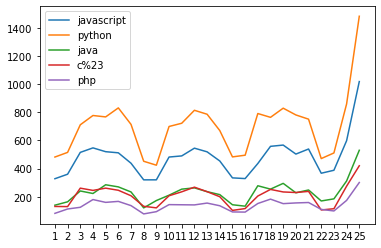

In [ ]:
import numpy as np
fig, ax = plt.subplots()
for tag in tags[:5]:
    trend_list = get_number_of_questions_per_day(25, tag)
    ax.plot(range(1, 26), list(reversed(trend_list)), label=tag)
    print(trend_list)
ax.legend()
# Set the locations of the x-axis tick marks
ax.set_xticks(np.arange(1, 26, 1))

# Set the labels of the x-axis tick marks
ax.set_xticklabels(np.arange(1, 26, 1))
plt.show()